In [1]:
## Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/emg-signal-for-gesture-recognition/EMG-data.csv')

In [3]:
# df = pd.DataFrame(columns=['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8', 'class'])

# Data_dir = "/kaggle/input/gesture-prediction-using-semg-data/Data"
# files = list()
# for dir in os.listdir(Data_dir):
#     for file in os.listdir(os.path.join(Data_dir,dir)):
#         file_df = pd.read_csv(os.path.join(Data_dir, dir, file), sep="\t")
#         file_df.drop('time', axis=1, inplace=True)
#         file_df.drop_duplicates(keep='last', subset=['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8', 'class'], inplace=True)
#         new_df = pd.concat([df, file_df],axis=0)
#         df = new_df

In [4]:
df.shape

(4237907, 11)

In [5]:
df.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1


In [6]:
# df.to_csv('/kaggle/working/transformed_data.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237907 entries, 0 to 4237906
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      int64  
 1   channel1  float64
 2   channel2  float64
 3   channel3  float64
 4   channel4  float64
 5   channel5  float64
 6   channel6  float64
 7   channel7  float64
 8   channel8  float64
 9   class     int64  
 10  label     int64  
dtypes: float64(8), int64(3)
memory usage: 355.7 MB


In [8]:
df.drop(['label','time'], inplace=True, axis=1)

In [9]:
## Changing the datatype of class feature from object to numeric one
df['class'] = df['class'].apply(pd.to_numeric)

In [10]:
df.dropna(inplace=True)

In [11]:
## Reading the newly created data
df.to_csv('/kaggle/working/transformed_data.csv', index=False)

In [12]:
X, y = df.drop('class', axis=1), df['class']

## scaling the data
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), columns= ['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8'])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=34, stratify=y)

In [14]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {X_train.shape[0]}.")
print(f"The number of columns in the train data are {X_train.shape[1]}.")

## checking the number of rows and columns in the X_test
print(f"The number of rows in the validation data are {X_val.shape[0]}.") 
print(f"The number of columns in the validation data are {X_val.shape[1]}.")

The number of rows in the train data are 3390325.
The number of columns in the train data are 8.
The number of rows in the validation data are 847582.
The number of columns in the validation data are 8.


In [15]:
## importing required tensorflow libraries
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras.callbacks as tkc

In [16]:
## creating a keras model
input_tensor = layers.Input(shape=X_train.shape[1:])
x = layers.Dense(1024, activation='relu')(input_tensor)
y = layers.Dense(512, activation='relu')(x)
z = layers.Dense(256, activation='relu')(y)
z = layers.Dropout(0.2)(z)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(64, activation='relu')(z)
z = layers.Dropout(0.2)(z)
z = layers.Dense(32, activation='relu')(z)
z = layers.Dense(128, activation='relu')(y) 
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
output_tensor = layers.Dense(8, activation='softmax')(z)

model = Model(input_tensor, output_tensor)

**This model parameters are borrowed from another kaggler's notebook. Please check out the original notebook too. I will leave the link to it here**

https://www.kaggle.com/code/drbilal216/emg-signal-complete-model

In [17]:
## compiling the model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
## creating checkpoints -- ModelCheckpoint and EarlyStopping
checkpoint_cb = tkc.ModelCheckpoint("gesture_predictor.h5",save_weights_only=True, monitor='val_loss')
early_stopping_cb = tkc.EarlyStopping(patience=5,restore_best_weights=True)

In [19]:
## training the model using training and validation set
history = model.fit(X_train, y_train, epochs=200, batch_size=512, validation_data=(X_val, y_val),callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200
6622/6622 [==============================] - 31s 4ms/step - loss: 0.9073 - accuracy: 0.6457 - val_loss: 0.8841 - val_accuracy: 0.6488
Epoch 2/200
6622/6622 [==============================] - 27s 4ms/step - loss: 0.8707 - accuracy: 0.6522 - val_loss: 0.8587 - val_accuracy: 0.6553
Epoch 3/200
6622/6622 [==============================] - 27s 4ms/step - loss: 0.8415 - accuracy: 0.6620 - val_loss: 0.8292 - val_accuracy: 0.6684
Epoch 4/200
6622/6622 [==============================] - 28s 4ms/step - loss: 0.8086 - accuracy: 0.6761 - val_loss: 0.8000 - val_accuracy: 0.6816
Epoch 5/200
6622/6622 [==============================] - 25s 4ms/step - loss: 0.7759 - accuracy: 0.6913 - val_loss: 0.7684 - val_accuracy: 0.6958
Epoch 6/200
6622/6622 [==============================] - 27s 4ms/step - loss: 0.7448 - accuracy: 0.7058 - val_loss: 0.7434 - val_accuracy: 0.7084
Epoch 7/200
6622/6622 [==============================] - 26s 4ms/step - loss: 0.7162 - accuracy: 0.7198 - val_loss: 0.7187 -

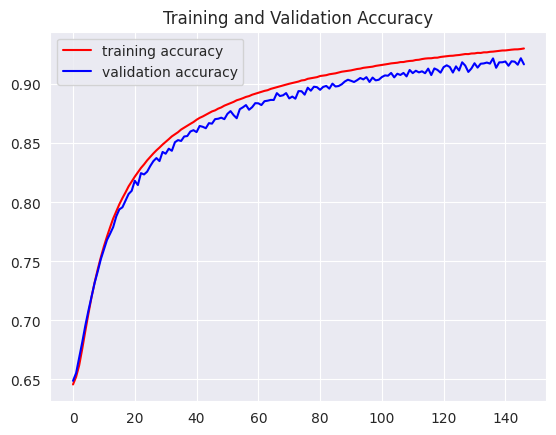

In [20]:
## visualizing the train and validation accuracy
sns.set_style('darkgrid')
plt.plot(history.history['accuracy'],color='red',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

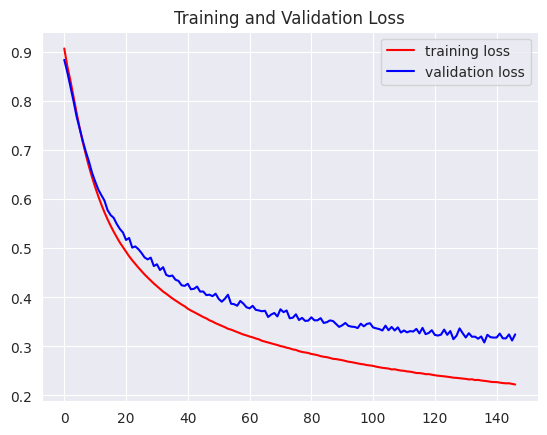

In [21]:
## visualizing the train and validation loss
plt.plot(history.history['loss'],color='red',label='training loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()